# ConnectX Agent through PPO Stable Baselines
This notebook implements stable baselines PPO in order to train a Connect x agent for the Kaggle competition. Some of the notebook is based on:

https://www.kaggle.com/code/nickmacd/ppo-using-sb3


# Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING logs

In [2]:
%%capture
from kaggle_environments import evaluate, make, utils
from gymnasium import spaces
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
import torch as th
import torch.nn as nn
import copy
import torch
import numpy as np

import random
import numpy as np
import pandas as pd
import gym
import gymnasium
import matplotlib.pyplot as plt
%matplotlib inline

2024-10-27 16:42:35.369639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 16:42:35.369794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 16:42:35.548401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Create ConnectX Environment

In [3]:
env = make("connectx", debug=True)
# env.render()
print(*env.agents)

random negamax


In [4]:
env.configuration

{'episodeSteps': 1000,
 'actTimeout': 2,
 'runTimeout': 1200,
 'columns': 7,
 'rows': 6,
 'inarow': 4,
 'agentTimeout': 60,
 'timeout': 2}

In [5]:
env.reset()
test = env.step((1,3))
env.render()

# Play Naive Agent

In [6]:
def naive(observation, configuration):
    # Number of Columns on the Board.
    columns = configuration.columns
    # Number of Rows on the Board.
    rows = configuration.rows
    # Number of Checkers "in a row" needed to win.
    inarow = configuration.inarow
    # The current serialized Board (rows x columns).
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark

    # Return which column to drop a checker (action).
    return 0

env = make("connectx", debug=True)
# play agent above vs default random agent.
env.run([naive, "random"])
env.render(mode="ipython", width=600, height=500, header=False)

# Create an agent to train against. Taken from:

https://www.kaggle.com/code/marekgp/exercise-n-step-lookahead

In [7]:
def train_agent(obs, config):

    N_STEPS = 5

    # Gets board at next step if agent drops piece in selected column
    def drop_piece(grid, col, mark, config):
        next_grid = grid.copy()
        for row in range(config.rows - 1, -1, -1):
            if next_grid[row][col] == 0:
                break
        next_grid[row][col] = mark
        return next_grid

    # Helper function for get_heuristic: checks if window satisfies heuristic conditions
    def check_window(window, num_discs, piece, config):
        return (
                window.count(piece) == num_discs
                and window.count(0) == config.inarow - num_discs
        )

    # Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
    def count_windows(grid, num_discs, piece, config):
        num_windows = 0
        # horizontal
        for row in range(config.rows):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(grid[row, col : col + config.inarow])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # vertical
        for row in range(config.rows - (config.inarow - 1)):
            for col in range(config.columns):
                window = list(grid[row : row + config.inarow, col])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # positive diagonal
        for row in range(config.rows - (config.inarow - 1)):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(
                    grid[
                        range(row, row + config.inarow), range(col, col + config.inarow)
                    ]
                )
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # negative diagonal
        for row in range(config.inarow - 1, config.rows):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(
                    grid[
                        range(row, row - config.inarow, -1),
                        range(col, col + config.inarow),
                    ]
                )
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        return num_windows

    # Helper function for minimax: calculates value of heuristic for grid
    def get_heuristic(grid, mark, config):
        num_threes = count_windows(grid, 3, mark, config)
        num_fours = count_windows(grid, 4, mark, config)
        num_threes_opp = count_windows(grid, 3, mark % 2 + 1, config)
        num_fours_opp = count_windows(grid, 4, mark % 2 + 1, config)
        score = (
                num_threes - 1e2 * num_threes_opp - 1e4 * num_fours_opp + 1e6 * num_fours
        )
        return score

        # Uses minimax to calculate value of dropping piece in selected column

    def score_move(grid, col, mark, config, nsteps):
        next_grid = drop_piece(grid, col, mark, config)
        score = minimax(next_grid, nsteps - 1, False, mark, config)
        return score

    # Helper function for minimax: checks if agent or opponent has four in a row in the window
    def is_terminal_window(window, config):
        return window.count(1) == config.inarow or window.count(2) == config.inarow

    # Helper function for minimax: checks if game has ended
    def is_terminal_node(grid, config):
        # Check for draw
        if list(grid[0, :]).count(0) == 0:
            return True
        # Check for win: horizontal, vertical, or diagonal
        # horizontal
        for row in range(config.rows):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(grid[row, col : col + config.inarow])
                if is_terminal_window(window, config):
                    return True
        # vertical
        for row in range(config.rows - (config.inarow - 1)):
            for col in range(config.columns):
                window = list(grid[row : row + config.inarow, col])
                if is_terminal_window(window, config):
                    return True
        # positive diagonal
        for row in range(config.rows - (config.inarow - 1)):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(
                    grid[
                        range(row, row + config.inarow), range(col, col + config.inarow)
                    ]
                )
                if is_terminal_window(window, config):
                    return True
        # negative diagonal
        for row in range(config.inarow - 1, config.rows):
            for col in range(config.columns - (config.inarow - 1)):
                window = list(
                    grid[
                        range(row, row - config.inarow, -1),
                        range(col, col + config.inarow),
                    ]
                )
                if is_terminal_window(window, config):
                    return True
        return False

    # Minimax implementation
    def minimax(node, depth, maximizingPlayer, mark, config):
        is_terminal = is_terminal_node(node, config)
        valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
        if depth == 0 or is_terminal:
            return get_heuristic(node, mark, config)
        if maximizingPlayer:
            value = -np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark, config)
                value = max(value, minimax(child, depth - 1, False, mark, config))
            return value
        else:
            value = np.Inf
            for col in valid_moves:
                child = drop_piece(node, col, mark % 2 + 1, config)
                value = min(value, minimax(child, depth - 1, True, mark, config))
            return value

    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]

    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    # Always start in the middle
    if grid.sum() == 0:
        return config.columns//2

    # Use the heuristic to assign a score to each possible board in the next step
    scores = dict(
        zip(
            valid_moves,
            [ score_move(grid, col, obs.mark, config, N_STEPS) for col in valid_moves],
        )
    )

    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]



    # Select at random from the maximizing columns
    return random.choice(max_cols)

# Create the wrapper to use with Kaggle ConnectX for training with SB3

In [8]:
class ConnectFourGym(gymnasium.Env):
    def __init__(self, player1_pct = 0.5, random_steps=1000):
        """Creates a custom connect4 environment compatible with SB3. it ineherents the base gynmasium env class
        :param player1_pct : probability of the trainer choosing the player as the first player during training
        :param random_steps : number of steps to train against a random opponent before choosing to play against 
        a more sophisticated opponent"""
        
        self.ks_env = make("connectx", debug=True)
        self.reset_count = 0

        self.rows = self.ks_env.configuration.rows
        self.columns = self.ks_env.configuration.columns
        
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=1.0,
                                            shape=(1,self.rows,self.columns), dtype=float)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-2, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
        self.device = 'cpu'
        
        self.step_count = 0
        self.player1_pct = player1_pct
        self.random_steps = random_steps
        
        self.self_play_model = None
        self.self_play = False

        self.env = self._trainer_maker(self.ks_env)

    def _trainer_maker(self, env):
        #if self.reset_count%100 == 0: print(f'Episode: {self.reset_count}')
        rand = torch.rand(1).item()
        
        if self.self_play:#if we are now playing against ourselves
            if rand < self.player1_pct:
                trainer = env.train([None, self._self_play])
            else:
                trainer = env.train([self._self_play, None])
            return trainer
        #otherwise, check to see if we are playing against a random opponent
        if self.reset_count < self.random_steps: 
            if rand < self.player1_pct:
                trainer = env.train([None, 'random'])
            else:
                trainer = env.train(['random', None])
                
        else: #after that we train it against a more 'advanced' player
            if rand < self.player1_pct: #train as second opponent 80% of the time, that's where the agent is struggling
                trainer = env.train([None, train_agent])
            else:
                trainer = env.train([train_agent, None])
        
        self.reset_count += 1
        return trainer
        
    def reset(self, seed=None, options=None):
        #reset the env and potentiall swap the training partern/position
        self.env = self._trainer_maker(self.ks_env)
        self.obs = self._convert_board(self.env.reset())
        return self.obs, {}
    
    def change_reward(self, old_reward, done):
        """Reward shaping function"""
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return -1/(self.rows*self.columns)
        
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs[0][0][int(action)] == 0)
        if is_valid: # Play the move
            obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
            self.obs = self._convert_board(obs)
        else: # End the game and penalize agent
            reward, done, _ = -2, True, {}
        if self.step_count%1000 == 0: print(f'Step: {self.step_count}')
        self.step_count += 1                
        return self.obs, reward, done, False, _
            
    def _convert_board(self, obs):
        """Takes the board and sets all of the marks for the agent equal to 0.5 and the opponents marks equal to 1"""
        board = torch.tensor(obs['board'], dtype=torch.float32, device=self.device)
        mark = obs['mark']
        board[(board !=mark) & (board != 0)] = 8
        board[board==mark] = 4
        board = board/8
        board = torch.reshape(board, (6,7))
        board = board.unsqueeze(dim=0)
        return board.numpy()    
    
    def _self_play(self, obs, config):
        board = self._convert_board(obs)
        action, _ = self.self_play_model.predict(board, deterministic=True)
        if board[0][0][action] == 0:
            # Return which column to drop a checker (action).
            return int(action)
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])
    
    def set_self_play_model(self, new_model):
        self.self_play_model = new_model
    
    def swap_self_play(self):
        self.self_play = not self.self_play
        
# Create ConnectFour environment 
env = ConnectFourGym()

# Check the environment

In [9]:
check_env(env)

Step: 0


/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:30: UserWarning: It seems that your observation  is an image but its `dtype` is (float64) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:38: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  warnings.warn(


# Custom callbacks that will swap the agent between self-play and external agent play. It will also periodically update the self-play agent as it learns.

In [10]:
class SelfPlayCallback(BaseCallback):
    
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        
    def _on_step(self):
        #this will trigger self train to be swap every 100 timesteps
        if self.num_timesteps%100 == 0:
            self.training_env.env_method('swap_self_play')
        if self.num_timesteps%1000 == 0:
            self.training_env.env_method('set_self_play_model', copy.deepcopy(self.model))
        return True

class SelfPlayInitCallback(BaseCallback):
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)

    def _on_training_start(self):
        #this will trigger self train to be swap every 100 timesteps
        self.training_env.env_method('set_self_play_model', copy.deepcopy(self.model))
        
    def _on_step(self):
        return True
    
sp_init_callback = SelfPlayInitCallback()
sp_callback = SelfPlayCallback()
callbacks = CallbackList([sp_init_callback, sp_callback])

# Create the neural network for the agent using a Convolutional Neural Network (CNN).

In [11]:
# Neural network for predicting action values
class CustomCNN(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int=128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # CxHxW images (channels first)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
)

# Train the agent

In [12]:
# Initialize agent
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=0)

# Train agent
model.learn(total_timesteps=18000, callback=callbacks)

/opt/conda/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.set_self_play_model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_self_play_model` for environment variables or `env.get_attr('set_self_play_model')` that will search the reminding wrappers.
  logger.warn(
/opt/conda/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.swap_self_play to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.swap_self_play` for environment variables or `env.get_attr('swap_self_play')` that will search the reminding wrappers.
  logger.warn(


Step: 1000
Step: 2000
Step: 3000
Step: 4000
Step: 5000
Step: 6000
Step: 7000
Step: 8000
Step: 9000
Step: 10000
Step: 11000
Step: 12000
Step: 13000
Step: 14000
Step: 15000
Step: 16000
Step: 17000
Step: 18000


# Plot Learning Stats

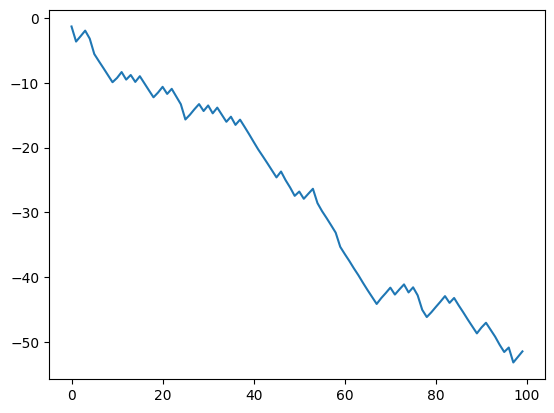

In [13]:
rewards = pd.Series([x['r'] for x in model.ep_info_buffer]).cumsum().plot()

# Define Agent

In [14]:
def my_agent(obs, config):
    board = torch.tensor(obs['board'], dtype=torch.float32)
    mark = obs['mark']
    board[(board !=mark) & (board != 0)] = 8
    board[board==mark] = 4
    board = board/8
    board = torch.reshape(board, (6,7))
    board = board.unsqueeze(dim=0) 
    action, _ = model.predict(board, deterministic=True)
    if board[0][0][action] ==0:
        # Return which column to drop a checker (action).
        return int(action)
    return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])


# Review Win Percentage

In [15]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [16]:
# Create the game environment
test_env = make("connectx")

# Two random agents play one game round
test_env.run([my_agent, "random"])

# Show the game
test_env.render(mode="ipython")

In [17]:
get_win_percentages(agent1=my_agent, agent2="random")

Agent 1 Win Percentage: 0.8
Agent 2 Win Percentage: 0.2
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


# Evaluate and Save Agent

In [18]:
def mean_reward(rewards, player=0):
    return sum(r[player] for r in rewards if r[player]>0) / float(len(rewards))

import pickle
# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=100)))
print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=100), player=1))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 0.88
Random Agent vs My Agent: 0.73
My Agent vs Negamax Agent: 0.1


In [19]:
#save agent
model.save('ppo_connectx')

# Write Submission File

This code was provided from Svendaj at:
https://www.kaggle.com/code/svendaj/connect-x-exercise-deep-rl-submission-v1/notebook#Define-neural-network-to-be-trained


In [20]:
%%writefile main.py
import os, sys, random
import numpy as np
from stable_baselines3 import PPO
import torch

cwd = '/kaggle_simulations/agent/'
if os.path.exists(cwd):
    sys.path.append(cwd)
else:
    cwd = ''

model = None

def agent(obs, config):
    global model
    # load the trained model
    if model == None:
        model = PPO.load(cwd + "ppo_connectx")
    #reshape the board into the expected output    
    board = torch.tensor(obs['board'], dtype=torch.float32)
    mark = obs['mark']
    board[(board !=mark) & (board != 0)] = 8
    board[board==mark] = 4
    board = board/8
    board = torch.reshape(board, (6,7))
    board = board.unsqueeze(dim=0)
    
    #predict the action
    action, _ = model.predict(board, deterministic=True)
    
    #if valid, return the action, else choose a random action
    if board[0][0][action] ==0:
        return int(action)
    return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])


Writing main.py


In [21]:
# pack files used for submission
!tar cvfz submission.tar.gz main.py ppo_connectx.zip

main.py
ppo_connectx.zip


# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents. It will verify that the submission can run remotely.

In [22]:
import sys
from kaggle_environments import utils, agent

out = sys.stdout
submission = utils.read_file("main.py")
agent = agent.get_last_callable(submission, path= submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")
env.render(mode="ipython")

Success!


# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.